In [12]:
# First, we will import two modules that are very useful for file handing.
import os, sys
import glob

import warnings

# Import the other useful modules
import numpy as np

# Load the plotting utility matplotlib with an alias plt.
import matplotlib.pyplot as plt

# The following line allows for plots to be rendered in this notebook. 
%matplotlib inline

import seaborn as sns
# Set seaborn defaults
sns.set()

Read coordinates from xyz file

In [13]:
def Read_trajectory_vmd(fileName, dims, nFramesEquil):
    '''
    XXX
    '''
    with open(fileName, 'r') as f:
        fLinesAll = f.readlines()
         
        # get number of particles, and remove that line
        data=fLinesAll.pop(0).strip().split()
        nPart = int(data[0])
        print(nPart)

        #skip frames to allow equilibration
        nLinesStart = nFramesEquil * nPart
        fLines = fLinesAll[nLinesStart:]

        # check to see how many frames, and if all are complete
        nLines = len(fLines)
        if nLines % nPart != 0:
            warnings.warn(f'Read_trajectory_vmd: Incomplete frame\n file {fileName}, nPart {nPart}, lines {nLines}')
            
        nFrames = nLines // nPart
        print(f'Read_trajectory_vmd: reading file {fileName}, nPart {nPart}, frames {nFrames}')
        
        
        positions = np.zeros([nFrames,nPart,dims],float)
        counter=0
        for frame in np.arange(nFrames):
            for atom in np.arange(nPart):
                data = fLines[counter].strip().split()
                #print('d = ',data[1:dims+1])
                positions[frame,atom,:] = data[1:dims+1]
                counter += 1
                
    return(nPart, nFrames, positions)
                
        

In [14]:
def Unwrap_coordinates(positions, sideLength):
    """
    XXX
    """
    
    (nFrames, nPart, dims) = positions.shape
    
    displacements = np.diff(positions,axis=0)
    print('ds',displacements.shape)
    ind = np.where(np.fabs(displacements) > 0.5*sideLength)
    #print('ind',ind)
    print('total displacements=',nFrames*nPart*dims, ' num to unwrap=',len(ind[0]))
    print('maxd',np.max(displacements))
    displacements[ind] -= np.sign(displacements[ind]) * sideLength
    print('maxd after unwrap',np.max(displacements))
    
    # Sum to get unwrapped coords
    tempArray = positions.copy()
    tempArray[1:,:,:] = displacements
    # sum displacements over frames
    unwrapped_positions = np.cumsum(tempArray, axis=0)
    
    return(unwrapped_positions)
    
    
    

In [15]:
def Get_msd(positions, frame_step, del0, del1):
    """
    XXX
    """
    (nFrames, nPart, dims) = positions.shape
    
    delt_array = np.arange(0,nFrames,del1) * frame_step 
    numDel = len(delt_array)
    numAtDelt = np.zeros(numDel, int)
    msdAtDelt = np.zeros(numDel, float)

    # Could use numpy better by avoiding these loops if want to speed things up
    #perform time average by ranging over t0's
    for t0_ind in np.arange(0, nFrames, del0):
        # store position at t=0
        pos0 = positions[t0_ind,:,:]
        #positions array indices are [nframes, nPart, dims]
        
        for delt_ind in np.arange(0, nFrames-t0_ind, del1):
            # avg over all particles (dx^2+dy^2+dz^2)
            msdAtDelt[delt_ind] += np.sum((positions[t0_ind+delt_ind,:,:]-pos0)**2) / nPart 
            numAtDelt[delt_ind] += 1
        
    # complete avg over t0's
    # need to check for numAtDelt = 0?
    msdAtDelt /= numAtDelt
    
    return(delt_array, msdAtDelt)


In [16]:
def Parse_filename(fName):
    fName=fName.rstrip('.xyz')
    print(fName)
    threeTuple = fName.rpartition('_pB')
    pBias_str = threeTuple[2]
    
    return (pBias_str)
    
    

In [17]:
pwd

'/workspaces/QBIO110'

In [18]:


# Parameters from MD code
dims = 3
timestep = 1
save_freq = 1
frame_step = save_freq * timestep
# skip frames for equilibrate
nFramesSkip = 0


# Read all files in directory matching filename format
fNameList = glob.glob('traj*.xyz')
print('files to read are')
print(fNameList)

delt=dict()
msd=dict()

for fName in fNameList:

    (pBias_str) = Parse_filename(fName)
    key=pBias_str

    print('reading file ',fName)
    print(f'pBias={pBias_str}')


    (nPart, nFrames, positions) = Read_trajectory_vmd(fName, dims, nFramesSkip)
    print(positions.shape)

    #don't need to unwrap
    #print('box_width=',box_width)
    #unwrapped_positions = Unwrap_coordinates(positions, box_width)

    # Check to make sure this worked
    #waste = Unwrap_coordinates(unwrapped_positions, box_width)

    (delt[key], msd[key]) = Get_msd(positions, frame_step, 1, 1)






files to read are
[]


/tmp/ipykernel_4430/3047354157.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


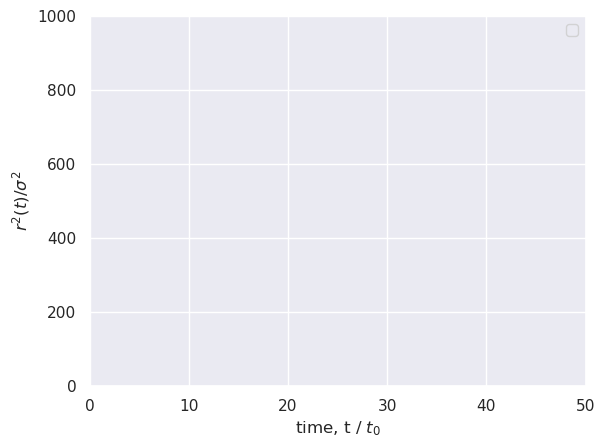

In [19]:
for key in sorted(delt.keys()):
    deltArray = delt[key]
    msdArray = msd[key]
    plt.plot(deltArray,msdArray,label=r'$p_\mathrm{{bias}}={pB:s}$'.format(pB=key))
    
plt.xlabel(r'time, t / $t_0$')
plt.ylabel(r'$r^2(t)/\sigma^2$')
plt.xlim(0,50)
plt.ylim(0,1000)
#ax=plt.gca()
#ax.set_ylim(top=20)
#plt.ylim(0,3)
plt.legend();
plt.show()
plt.savefig('MSD_for_random_walk.pdf')


#### Fit to model for persistent random walk

$\def\pBias{p_\mathrm{bias}}$
let $\rho=\frac{\langle x(1)\cdot x(0)\rangle>}{a^2}=2\pBias-1$; i.e., the correlation between successive steps, with $x(t)$ the step **vector** at time $t$ and $a$ the mean step length.

Then, the correlation function  is defined as $C(m)=\exp(-m / \tau)$ where $m$ is number of steps and $\tau$ is the correlation time (in number of steps). Further, see that $C(m)=\rho^m$, so that $\tau=\frac{1}{-\log \rho}=-\frac{1}{\log\left(2\pBias-1\right)}.$


Persistent Random Walk scaling:

$\langle R^2(t) \rangle = 2Dt +  2 D \tau\left(e^{-t/\tau}-1\right)$

However, in this equation $D$ depends on $\pBias$. Note that the mean time of a run is $\tau$ and the mean length of a run is $v_0 \tau$ with $v_0=a/\Delta t$ the *speed* of the walk during its runs, with $a$ the individual step length and $\Delta t$ the timestep. Thus, $D=(v_0 \tau)^2/\tau=v_0^2\tau$, so

$\langle R^2(t) \rangle = 2 v_0^2 \tau t +  2 v_0^2 \tau^2\left(e^{-t/\tau}-1\right)$

In [20]:
def R2RW(t, dims, D, tau):
    return(2*dims*D * ( t +  tau * (np.exp(-t/tau) - 1)))
def R2Ballistic(t, dims, v0):
    return(dims * v0**2 * t**2)

In [21]:
delt.keys()

dict_keys([])

In [24]:
key = '0.9'

deltArray = delt[key]
msdArray = msd[key]
plt.plot(deltArray,msdArray,'b-o',label='numerical')
v0=1 #this is 'speed'; i.e. v0 * dt = a, with a the step length
# setting a=1 and dt=1 gives v0=1
pBias = float(key)
#tau = 1/(1-pBias)   #np.exp(1-pBias)
tau = 1/(-np.log(2*pBias-1))
D = v0**2 * tau
print('tau=',tau)
plt.plot(deltArray, R2RW(deltArray, dims, D, tau),'r-x',label='theory')
         

plt.title(r'$p_\mathrm{{bias}}={pB:s}$'.format(pB=key))

plt.xlabel(r'time, t / $t_0$')
plt.ylabel(r'$r^2(t)/\sigma^2$')
plt.xlim(0,50)
plt.ylim(0,500)
#ax=plt.gca()
#ax.set_ylim(top=20)
#plt.ylim(0,3)
plt.legend();
#plt.savefig('MSD_for_random_walk.pdf')



KeyError: '0.9'

tau= 1.0


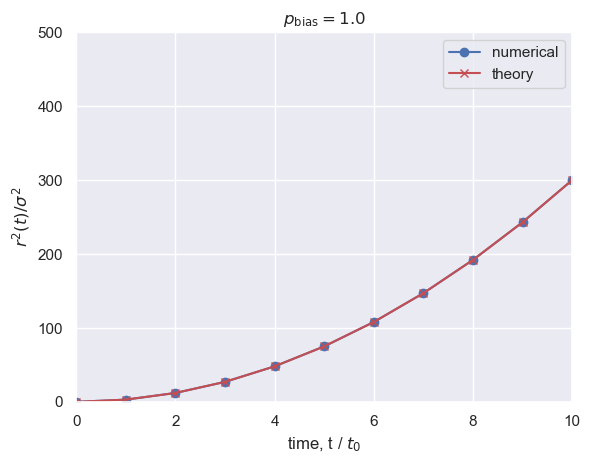

In [ ]:
key = '1.0'

deltArray = delt[key]
msdArray = msd[key]
plt.plot(deltArray,msdArray,'b-o',label='numerical')
v0=1
pBias = float(key)
#tau = 1/(1-pBias)  #np.exp(1-pBias)
tau = np.exp((1-pBias))
print('tau=',tau)
plt.plot(deltArray, R2Ballistic(deltArray, dims, v0),'r-x',label='theory')
         

plt.title(r'$p_\mathrm{{bias}}={pB:s}$'.format(pB=key))

plt.xlabel(r'time, t / $t_0$')
plt.ylabel(r'$r^2(t)/\sigma^2$')
plt.xlim(0,10)
plt.ylim(0,500)
#ax=plt.gca()
#ax.set_ylim(top=20)
#plt.ylim(0,3)
plt.legend();
#plt.savefig('MSD_for_random_walk.pdf')

